In [0]:
# We need to install few packages, the below libraries are not inbuild in the
# underying google colab machine. Few of the libraies are for baseline and 
# gym. And few for displaying the animation.
!apt-get update &&  apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym[atari_py]
!apt install ffmpeg
!pip install stable_baselines
!pip install box2d-py
!pip install gym[Box_2D]
!pip install imageio

In [0]:
import gym, time, imageio, os
import matplotlib.pyplot as plt
import numpy as np
from pyvirtualdisplay import Display
from matplotlib.image import imread
from matplotlib import rc, animation
from stable_baselines import DQN
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.bench import Monitor
%matplotlib inline

try:
  from google.colab import files
except:
  print("Could not import Google Colab.")
  
display = Display(visible=0, size=(400, 300))
display.start()
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'


In [0]:
best_mean_reward, n_steps = -np.inf, 0
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
def callback(_locals, _globals):
  """
  Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
  :param _locals: (dict)
  :param _globals: (dict)
  """
  global n_steps, best_mean_reward
  # Print stats every 1000 calls
  if (n_steps + 1) % 1000 == 0:
      # Evaluate policy performance
      x, y = ts2xy(load_results(log_dir), 'timesteps')
      if len(x) > 0:
          mean_reward = np.mean(y[-100:])
          print(x[-1], 'timesteps')
          print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

          # New best model, you could save the agent here
          if mean_reward > best_mean_reward:
              best_mean_reward = mean_reward
              # Example for saving best model
              print("Saving new best model")
              _locals['self'].save(log_dir + 'best_model.pkl')
  n_steps += 1
  return True

In [0]:
#First step is to get an environment in which we can run reinforcement learning

# Environment description:

#Rewards: 
#  Moving from the top of the screen to landing pad and zero speed is about 100 to 140 points. 
#  If lander moves away from landing pad it loses reward back. 
#  Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
#  Each leg ground contact is +10. Firing main engine is -0.3 points each frame. 
#  Solved is 200 points. Landing outside landing pad is possible. 
#  Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 

#Actions available: 
#do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

env = gym.make('LunarLander-v2')
env = Monitor(env, log_dir, allow_early_resets=True)
#DummyVecEnv creates a simple vectorized wrapper for multiple environments, meaning
#   this is the way to multiprocess training, hence we have a vectorized environment

env = DummyVecEnv([lambda: env])

#Here we are using the DQN implementation by stable baseline
model = DQN(MlpPolicy, env, verbose=1)

#Agents gets trained at this step, training with 50k steps and calling the callback
#for plotting the results, this will show how well the agent is learning, and 
#performing, at each point rewards are collected in the callback.
model.learn(total_timesteps=25000, callback=callback)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


997 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -229.02
1844 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -209.24
2827 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -208.51
3742 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -190.79
4816 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -176.48
5099 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -177.24
6099 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -176.73
7099 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -171.73
8099 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -168.47
9915 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -166.17
10915 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -166.63
11915 timesteps
Best mean reward: -75.48 - Last mean reward per episode: -167.11
12915 timesteps
Best mean reward: -75.4

In [0]:
#We initalize the frames array so that we can collect each frame, and use it for
# animation.
frames=[]
obs = env.reset()
for i in range(1000):
    #we let the model predict here, which returns the action and states
    action, _states = model.predict(obs)
    #step function performs the particular action, that was predicted out of the 
    #neural network model.
    obs, rewards, dones, info = env.step(action)
    screen = env.render(mode='rgb_array')
    #we simple collect all the images, which can be used later for animation
    frames.append(screen)

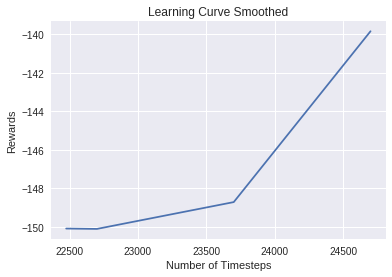

In [0]:
def movingAverage(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = movingAverage(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
plot_results(log_dir)

In [0]:
# Saving the predicted episode as a gif for viewing it
imageio.mimsave('lander.gif', [np.array(img) for i, img in enumerate(frames) if i%2 == 0], fps=29)
files.download('lander.gif')
